In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
import zipfile

In [3]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

In [4]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# **load and preprocess the images**

In [5]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

***labeling images***

In [6]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

***Load and visualize cat images***

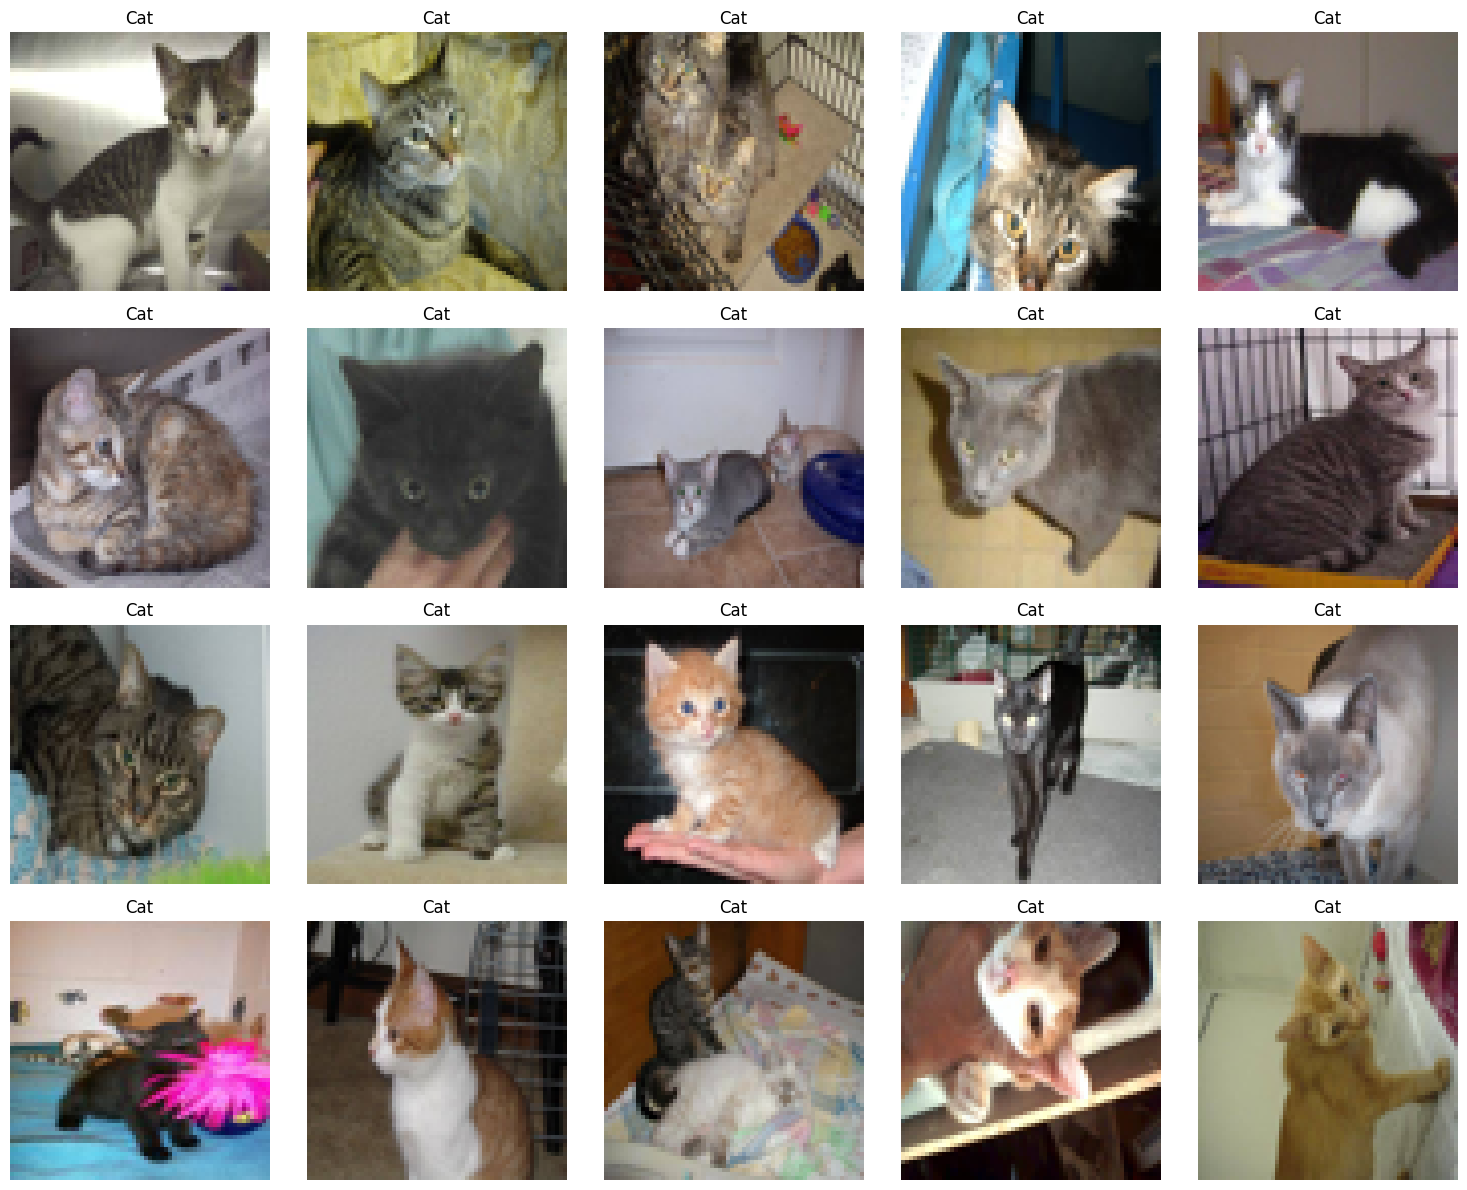

In [7]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

***Load and visualize dog images***

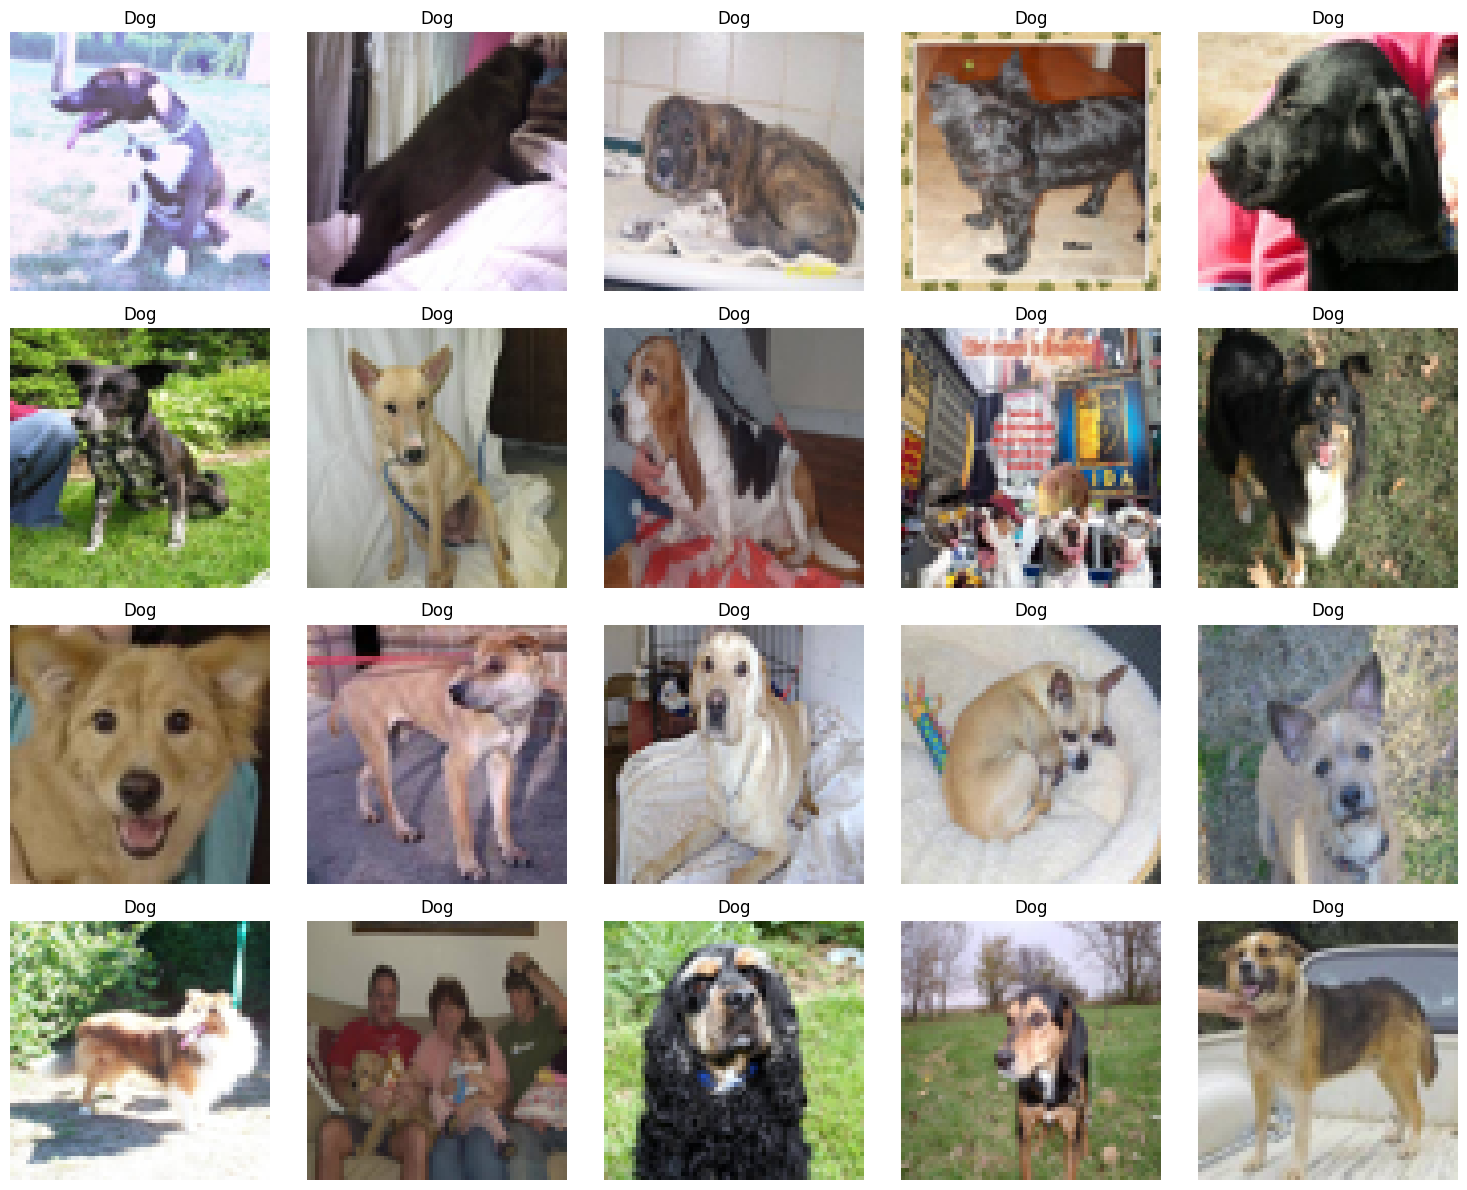

In [8]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

In [9]:
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

In [10]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


In [11]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


In [12]:
print(images[:2])
print(labels[:2])

[[[[0.00352172 0.00127643 0.00184544]
   [0.00352172 0.00127643 0.00184544]
   [0.00349097 0.00124567 0.00181469]
   ...
   [0.00349097 0.0016609  0.0020915 ]
   [0.00344483 0.00161476 0.00201461]
   [0.00346021 0.00163014 0.00196847]]

  [[0.00347559 0.0012303  0.00179931]
   [0.00355248 0.00130719 0.0018762 ]
   [0.00352172 0.00127643 0.00184544]
   ...
   [0.00355248 0.00161476 0.00206075]
   [0.00350634 0.00161476 0.00207612]
   [0.00347559 0.00163014 0.0020915 ]]

  [[0.00341407 0.00116878 0.00175317]
   [0.00358324 0.00132257 0.00192234]
   [0.00358324 0.00133795 0.00190696]
   ...
   [0.00359862 0.00153787 0.00206075]
   [0.00352172 0.00155325 0.00207612]
   [0.00346021 0.00159938 0.00213764]]

  ...

  [[0.00370627 0.00133795 0.00213764]
   [0.00372165 0.00135333 0.00215302]
   [0.0037524  0.00138408 0.00218378]
   ...
   [0.0038293  0.00156863 0.00233756]
   [0.00372165 0.0014456  0.00221453]
   [0.00362937 0.00135333 0.00212226]]

  [[0.00367551 0.00130719 0.00210688]
   [0.0

In [13]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

In [14]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

In [15]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [17]:
X_train

array([[ 1.58580773,  1.59225966,  1.59155231, ..., -1.60732191,
        -1.53494029, -1.43046689],
       [ 0.38521568,  0.64062993,  0.61791092, ..., -1.51878894,
        -1.48958453, -1.3715691 ],
       [ 0.38521568,  0.75597899,  0.34980677, ..., -0.76625873,
        -0.74877374, -0.73841783],
       ...,
       [ 0.22799529,  0.61179266,  0.46269273, ..., -0.69248125,
        -0.12891166, -0.547     ],
       [-0.37230074, -0.65704698, -0.59561312, ..., -0.22030543,
        -0.86972244, -1.3715691 ],
       [-1.11552439, -1.14728048, -1.11771068, ..., -1.74012135,
        -1.68612616, -1.53353803]])

In [18]:
X_val

array([[-0.31512969, -0.22448801, -0.17229078, ..., -0.67772576,
        -1.18721278, -1.38629355],
       [ 0.34233739,  0.07830327, -0.00296185, ..., -0.35310488,
        -0.37080906, -0.119991  ],
       [ 0.05648214, -0.21006938, -0.69438834, ...,  1.18146653,
         0.92938946,  0.79292479],
       ...,
       [-1.40137964, -1.34914133, -1.23059664, ..., -0.5596818 ,
        -0.47663917, -0.81204007],
       [-0.02927444, -0.03704579,  0.03937039, ..., -0.29408291,
        -0.28009753,  0.07142683],
       [ 0.27087358,  0.33783865,  0.29336379, ...,  0.16333742,
         0.30952738,  0.48371138]])

In [19]:
y_val

array([0, 0, 0, ..., 0, 1, 0])

In [20]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4995, 1: 5005}


In [21]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [22]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [23]:
y_val_pred = svm.predict(X_val)

In [24]:
y_val_pred

array([0, 0, 1, ..., 0, 0, 0])

In [25]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [26]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5530


In [27]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.54      0.61      0.57       976
         Dog       0.57      0.50      0.53      1024

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.56      0.55      0.55      2000



Validation Confusion Matrix:
[[595 381]
 [513 511]]


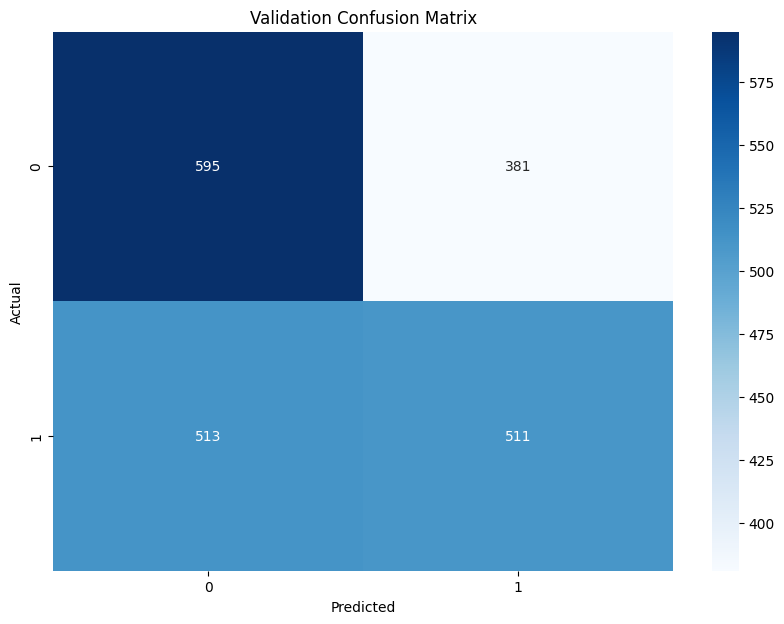

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

In [29]:
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [30]:
test_images, test_labels = load_images(test_dir)
test_images = test_images / 255.0

In [31]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

In [32]:
test_images_flat_scaled = scaler.transform(test_images_flat)

In [33]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

In [34]:
y_test_pred = svm.predict(test_images_flat_scaled)

In [35]:
y_test_pred

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1])

In [36]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

In [37]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [38]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [39]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [40]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set


In [41]:
plot_samples(val_images_tsne, y_val, y_val_pred)